# IoT Energy Consumption Prediction using Multiple Linear Regression
This analysis uses an **IoT-based dataset** that records environmental and operational changes measured by sensors. The dataset includes three independent variables:

- **Temperature Change (°C)** – variation in surrounding temperature  
- **Pressure Change (hPa)** – fluctuation in air pressure levels  
- **Speed Change (km/h)** – change in movement or flow speed  

The dependent variable is **Energy Change (kWh)**, which represents the variation in energy consumption.  
Multiple Linear Regression (MLR) is applied to understand how these predictors influence energy usage.  
By validating regression assumptions, the study ensures accurate, reliable predictions that can support energy monitoring and optimization in IoT systems.  


## 1. Importing Libraries and Dataset

In [15]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
plt.style.use('seaborn-v0_8')

In [30]:
# Load and rename columns
col_map = {'temp_sensor1':'temperature_change', 'humidity_sensor2':'pressure_change',
           'motion_device3':'speed_change', 'energy_usage':'energy_change'}

df = pd.read_csv('iot_dataset.csv').rename(columns=col_map)
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (185, 4)


,temperature_change,pressure_change,speed_change,energy_change
0,2.284686,0.116052,-1.291926,47.413554
1,NaN,-0.108015,1.505299,NaN
2,-0.527270,-1.512129,-2.806188,-256.139900
3,0.113707,-0.018370,-1.345882,-94.476198
4,-0.698595,0.813840,-0.695127,-77.635197


## 2. EDA and Pre-Processing

In [31]:
# Dataset info and missing values
print("Missing values:")
print(df.isna().sum())

Missing values:
temperature_change    13
pressure_change        7
speed_change          10
energy_change          9
dtype: int64


In [51]:
# Check for duplicate rows
print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 0


In [32]:
print("\nDataset info:")
df.info()


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature_change  172 non-null    float64
 1   pressure_change     178 non-null    float64
 2   speed_change        175 non-null    float64
 3   energy_change       176 non-null    float64
dtypes: float64(4)
memory usage: 5.9 KB


In [53]:
print("\nSummary statistics:")
df.describe().T


Summary statistics:


,count,mean,std,min,25%,50%,75%,max
temperature_change,172.0,0.013788,1.533634,-3.929618,-1.055186,0.062511,0.947805,5.779097
pressure_change,178.0,0.101267,1.322017,-2.707323,-0.905123,0.141629,0.863290,3.284704
speed_change,175.0,-0.263727,1.453278,-4.861901,-1.288831,-0.351230,0.986286,3.471988
energy_change,176.0,-13.244238,151.213559,-467.276710,-101.385105,-22.974592,67.527987,485.760896


In [34]:
# Drop rows with missing values
df_clean = df.dropna()
print(f"After dropping missing values: {df_clean.shape}")

After dropping missing values: (151, 4)


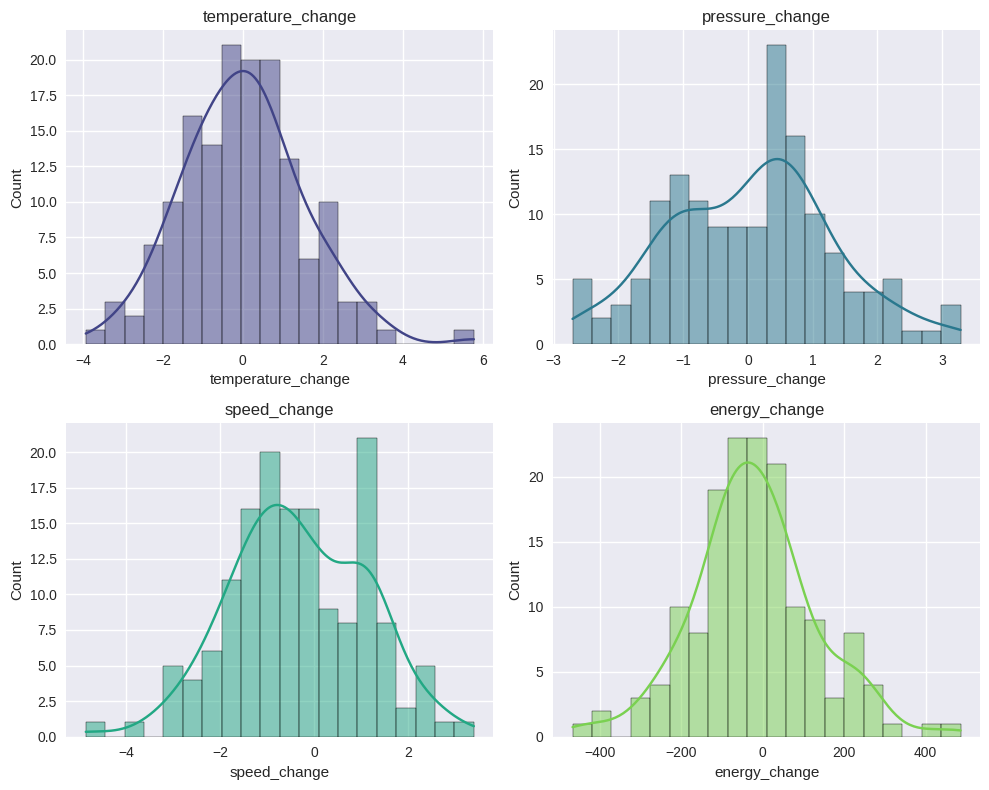

In [35]:
# Distribution plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
colors = sns.color_palette('viridis', n_colors=len(df_clean.columns))
for i, col in enumerate(df_clean.columns):
    row, col_idx = i // 2, i % 2
    sns.histplot(data=df_clean, x=col, bins=20, ax=axes[row, col_idx], color=colors[i], kde=True)
    axes[row, col_idx].set_title(f'{col}')
plt.tight_layout()
plt.show()

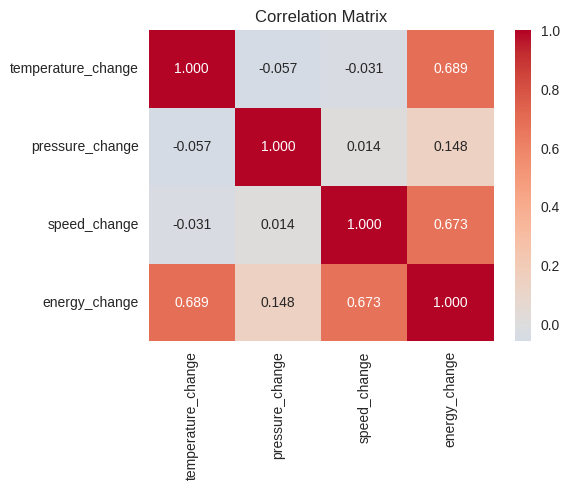

In [36]:
# Correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(df_clean.corr(), annot=True, fmt='.3f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

## 3. MLR Model Training

In [37]:
# Prepare data
y = df_clean['energy_change']
X = df_clean.drop(columns=['energy_change'])
X_const = sm.add_constant(X)

# Fit OLS model
model = sm.OLS(y, X_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          energy_change   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4340.
Date:                Sat, 20 Sep 2025   Prob (F-statistic):          3.17e-143
Time:                        16:10:55   Log-Likelihood:                -632.69
No. Observations:                 151   AIC:                             1273.
Df Residuals:                     147   BIC:                             1285.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6420      1

## 4. Assumption Validation
### 1. Linearity

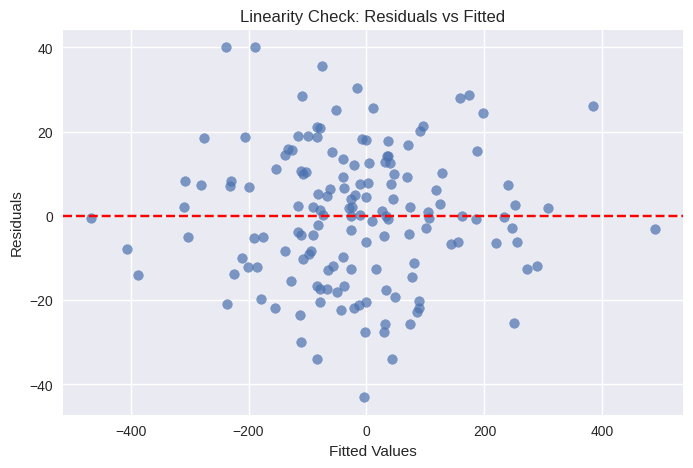

✓ Linearity: Look for random scatter around zero


In [58]:
# Residuals vs Fitted
resid = model.resid
fitted = model.fittedvalues

plt.figure(figsize=(8, 5))
plt.scatter(fitted, resid, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Linearity Check: Residuals vs Fitted')
plt.show()

print("✓ Linearity: Look for random scatter around zero")

Linearity
- Assumes predictors (temperature, pressure, speed) relate linearly to energy change.  
- Checked using scatter plots or residual vs. fitted value plots.  
- If the relationship isn’t straight, predictions may not reflect reality.  
- Non-linear trends distort coefficient interpretations.  
- **Fix:** Apply transformations (log, polynomial) or use robust regression.  

### 2. Independence

In [39]:
# Durbin-Watson Test
dw_stat = durbin_watson(resid)
print(f"Durbin-Watson statistic: {dw_stat:.3f}")
if 1.5 <= dw_stat <= 2.5:
    print("✓ Independence: No autocorrelation detected")
else:
    print("⚠ Warning: Possible autocorrelation")

Durbin-Watson statistic: 2.097
✓ Independence: No autocorrelation detected


Independence
- Assumes each observation of energy change is independent.  
- Checked with Durbin-Watson test, especially for time-series IoT data.  
- If residuals are correlated, results may falsely suggest strong relationships.  
- Independence ensures each data point contributes uniquely.  
- **Fix:** Use time-series or GLS models when dependency exists.

### 3. Homoscedasticity: Breusch-Pagan Test

Breusch-Pagan p-value: 0.8462


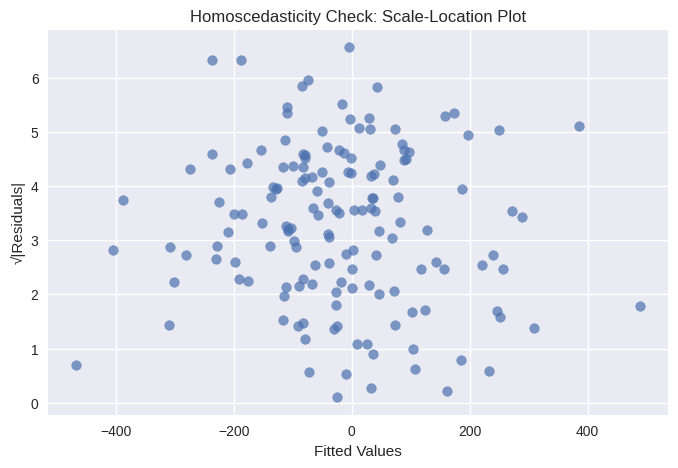

✓ Homoscedasticity: Constant variance confirmed


In [40]:
# Breusch-Pagan Test
bp_test = het_breuschpagan(resid, X_const)
bp_pvalue = bp_test[1]
print(f"Breusch-Pagan p-value: {bp_pvalue:.4f}")

# Scale-location plot
plt.figure(figsize=(8, 5))
plt.scatter(fitted, np.sqrt(np.abs(resid)), alpha=0.7)
plt.xlabel('Fitted Values')
plt.ylabel('√|Residuals|')
plt.title('Homoscedasticity Check: Scale-Location Plot')
plt.show()

if bp_pvalue > 0.05:
    print("✓ Homoscedasticity: Constant variance confirmed")
else:
    print("⚠ Warning: Heteroscedasticity detected")

Homoscedasticity
- Residuals should have constant spread across predicted energy values.  
- Checked by plotting residuals against fitted values.  
- If spread increases/decreases, heteroscedasticity exists.  
- This causes biased standard errors and weak statistical power.  
- **Fix:** Apply transformations or use heteroscedasticity-robust errors.  

### 4. Normality

Shapiro-Wilk: W=0.9956, p-value=0.9370


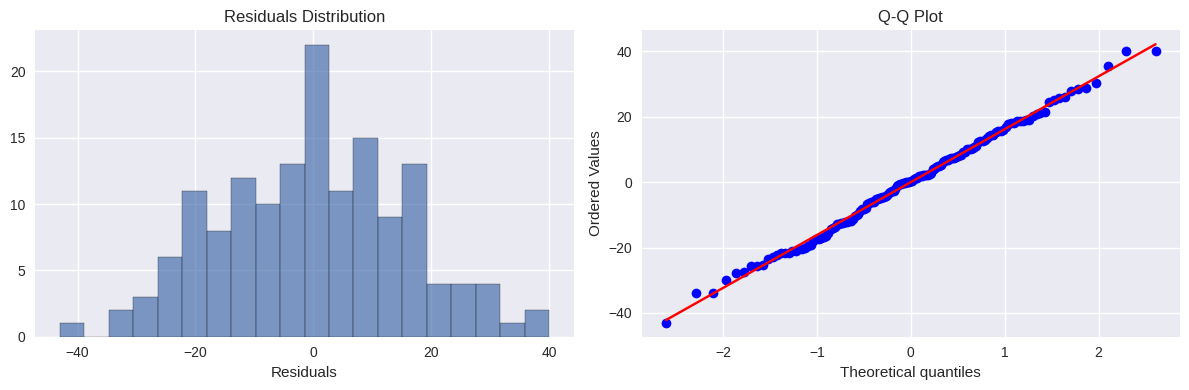

✓ Normality: Residuals are normally distributed


In [41]:
# Shapiro-Wilk Test and Q-Q Plot
W, shapiro_p = stats.shapiro(resid)
print(f"Shapiro-Wilk: W={W:.4f}, p-value={shapiro_p:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Histogram
axes[0].hist(resid, bins=20, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Residuals')
axes[0].set_title('Residuals Distribution')

# Q-Q plot
stats.probplot(resid, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot')
plt.tight_layout()
plt.show()

if shapiro_p > 0.05:
    print("✓ Normality: Residuals are normally distributed")
else:
    print("⚠ Warning: Normality assumption may be violated")

 Normality of Residuals
- Residuals = actual energy change – predicted energy change.  
- Should follow a normal (bell-shaped) distribution.  
- Verified with histograms, Q-Q plots, or statistical tests.  
- If not normal, confidence intervals and hypothesis tests may be misleading.  
- **Fix:** Transform data or apply non-parametric methods.  

#### 5. Multicollinearity

In [42]:
# VIF (Variance Inflation Factor)
vif_data = pd.DataFrame({
    'Feature': X_const.columns,
    'VIF': [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
})
print("VIF Values:")
print(vif_data)

high_vif = vif_data[vif_data['VIF'] > 5]
if len(high_vif) == 0:
    print("\n✓ No Multicollinearity: All VIF < 5")
else:
    print(f"\n⚠ Warning: High multicollinearity in: {high_vif['Feature'].tolist()}")

VIF Values:
              Feature       VIF
0               const  1.053197
1  temperature_change  1.004170
2     pressure_change  1.003413
3        speed_change  1.001083

✓ No Multicollinearity: All VIF < 5


Multicollinearity
- Predictors (temperature, pressure, speed) shouldn’t be strongly correlated.  
- Checked using Variance Inflation Factor (VIF).  
- High correlation makes it hard to separate individual effects on energy change.  
- Leads to unstable coefficients and inflated standard errors.  
- **Fix:** Remove/reduce correlated predictors or use PCA.  


## 5. Final Assumption Validation Summary

In [48]:
# Final assumption validation summary
print("\nFINAL ASSUMPTION VALIDATION:")
print("="*35)

# Re-run key tests on final model
dw_final = durbin_watson(resid)
bp_final = het_breuschpagan(resid, X_const)[1]
W_final, p_final = stats.shapiro(resid)

assumptions = [
    ("Linearity", "Visual inspection", "✓ Random scatter"),
    ("Independence", f"DW={dw_final:.3f}", "✓ Pass" if 1.5 <= dw_final <= 2.5 else "⚠ Check"),
    ("Homoscedasticity", f"BP p={bp_final:.4f}", "✓ Pass" if bp_final > 0.05 else "⚠ Check"),
    ("Normality", f"SW p={p_final:.4f}", "✓ Pass" if p_final > 0.05 else "⚠ Check"),
    ("No Multicollinearity", "VIF check", "✓ Pass" if len(high_vif) == 0 else "⚠ Check")
]

for assumption, test, result in assumptions:
    print(f"{assumption:18} | {test:12} | {result}")

print("\n" + "="*35)


FINAL ASSUMPTION VALIDATION:
Linearity          | Visual inspection | ✓ Random scatter
Independence       | DW=2.097     | ✓ Pass
Homoscedasticity   | BP p=0.8462  | ✓ Pass
Normality          | SW p=0.9370  | ✓ Pass
No Multicollinearity | VIF check    | ✓ Pass



## 6. Predictions for new sample data

In [61]:
# Generate some new sample data for prediction
sample_data = pd.DataFrame({
    'temperature_change': [1.5, -0.8, 0.2, 2.1, -1.5],
    'pressure_change': [-0.5, 1.2, 0.0, -0.3, 0.7],
    'speed_change': [0.8, -1.0, -0.3, 1.5, -0.5]
})

# Add a constant term to the sample data
sample_data_const = sm.add_constant(sample_data, has_constant='add')

# Make predictions
predictions = model.predict(sample_data_const)

# Display the predictions
print("Predictions for new sample data:")
print(predictions)

Predictions for new sample data:
0    156.107511
1   -104.071643
2     -6.896090
3    254.650160
4   -128.611586
dtype: float64


In [60]:
# Save the model
import pickle

model_filename = 'iot_energy_model.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved to {model_filename}")

Model saved to iot_energy_model.pkl


## 6. Conclusion

The IoT dataset demonstrates how changes in **temperature, pressure, and speed** influence **energy consumption (kWh)**.  
Multiple Linear Regression provides a framework to quantify these relationships and predict future energy changes.  

By checking assumptions—linearity, normality, homoscedasticity, independence, and multicollinearity—the model ensures valid and trustworthy results.  
Addressing any violations strengthens prediction quality, making this model a useful decision-support tool for energy management in IoT-driven environments.  